In [2]:
import sys
import os
from glob import glob
sys.path.append("../../marineHeatWaves/")
sys.path.append("../analysis/physiology/")

import sys
import time
oldstderr = sys.stderr
sys.stderr = open('log.txt', 'w')

import numpy as np

import sentinelsat
import satpy
from pyresample import create_area_def, AreaDefinition
from satpy.writers import compute_writer_results
import requests
from requests import auth, get

import xarray as xr

import warnings
warnings.filterwarnings("ignore")

import rasterio as rio
from rasterio import mask

import pandas as pd
import tqdm
from multiprocessing import Pool

from cartopy import crs as ccrs
import seaborn as sns
import matplotlib.pyplot as plt


import tqdm

# coda_auth = auth.HTTPBasicAuth('tonycan', os.environ['ss_pass'])


from shapely import geometry, wkt
from shapely.ops import transform
import pyproj

from dask.distributed import Client
from dask.diagnostics import ProgressBar
from dask import delayed
from multiprocessing.pool import ThreadPool as Pool
from multiprocessing import cpu_count

from functools import partial
from itertools import zip_longest, cycle, chain

import gcsfs

In [ ]:
client = Client()

In [146]:
os.environ['ss_pass'];

In [3]:
mp_pool = Pool(cpu_count() - 1)

# Whole Record, One Isolate Sentinel 3 Validation

I think I'm going to take the entire Sentinel 3 Record over a single spot and look at the relationship between chlorophyll + performance throughout that period, perhaps punctuated by s3?

The general question here is whether chlorophyll-a patterns can be explained by performance, where MHWs are a particular subset of "

In [7]:
plankton = pd.read_csv("../data/Phytoplankton_temperature_growth_rate_dataset_2016_01_29/traits_derived_2016_01_29.csv", engine='python')

plankton = plankton[
    (plankton.habitat == 'marine') & 
    (plankton.curvequal == 'good')
]


We'll only use the NE-Pacific isolate (#240)

In [8]:
chosen_isolate = plankton[plankton['isolate.code'] == 240]

## Acquire Entire Sentinel-3 Record for this Region

In [147]:
s3_api_historical = sentinelsat.SentinelAPI(
    'tonycan', 
    os.environ['ss_pass'], 
    api_url = 'https://codarep.eumetsat.int/'
)
s3_api_recent = sentinelsat.SentinelAPI(
    'tonycan', 
    os.environ['ss_pass'], 
    api_url = 'https://coda.eumetsat.int/'
)


In [148]:
isolate_mhw_wkt = wkt.dumps(
    geometry.Polygon.from_bounds(
        *geometry.Point([
            chosen_isolate['isolation.longitude'],
            chosen_isolate['isolation.latitude']
        ]).buffer(2).bounds
    )
)

In [149]:
queryParams = dict(
    area = isolate_mhw_wkt, 
    producttype='OL_2_WRR___',
    date = ('20160101', '20191231')
)

qr_historical = s3_api_historical.query(**queryParams)
qr_recent = s3_api_recent.query(**queryParams)

In [150]:
s3_result_combined = pd.concat([
    s3_api_historical.to_geodataframe(qr_historical),
    s3_api_recent.to_geodataframe(qr_recent)
])

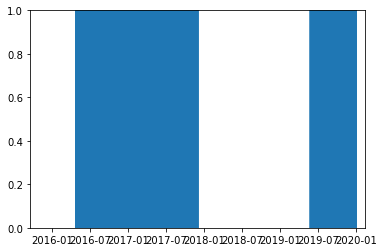

In [151]:
ax = plt.axes()
[ax.axvline(x.beginposition) for _, x in s3_result_combined.iterrows()];


Clearly there's a data gap in 2018, I can't really explain this. ~~Let's just do the historical data from `codarep`.~~ I think I'll actually do both, because it's ince to have two non-mhw years to compare to?

In [ ]:
s3_result_historical = s3_api_historical.to_geodataframe(qr_historical)

In [18]:
def download_image(image, path, auth):
    _, image = image
    r = get(image.link, auth=auth)
    exitpath = os.path.join(path, f'{image.title}.zip')
    with open(exitpath, 'wb') as f:
        f.write(r.content)
    return(exitpath)

In [19]:
download_location = '/tmp/nepacs3/historical/'
os.makedirs(download_location, exist_ok=True)
download_func = partial(download_image, path=download_location, auth=coda_auth)

NameError: name 'coda_auth' is not defined

In [6]:
mp_pool.map(download_func, s3_result_historical.iterrows())

NameError: name 'download_func' is not defined

In [152]:
s3_result_recent = s3_api_recent.to_geodataframe(qr_recent)

In [157]:
download_location = '/tmp/nepacs3/recent/'
os.makedirs(download_location, exist_ok=True)
download_func = partial(download_image, path=download_location, auth=coda_auth)

In [ ]:
mp_pool.map(download_func, s3_result_recent.iterrows())

**Unzip all of the data**:

In [ ]:
%%bash -s "$download_location"
ls ${1}*.zip | parallel -t unzip -d ${1}{} > /dev/null

## Process `chl_oc4me` and `chl_nn` data

**Note**: I initially tried to run the following code in parallel in this notebook, but ran into issues with dask/satpy locality and pickling rasterio objects. Spent the better part of a day working that out, and couldn't figure it out. The final solution was to break the `reproject_and_save` function out into its own module (`reproject_s3.py`) and ran that using `gnu parallel` as follows: 

    find . -name "*.SEN3" -type d | parallel --no-notice -k  "python /home/ec2-user/mhw_stressviz/validation/reproject_s3.py {}"
    
I will keep the old stuff here for posterity + reference. 

In [ ]:
# def reproject_and_save(img_directory, projection=ccrs.Mercator()):
#     chl_data = ['chl_oc4me', 'chl_nn']

#     _sc = satpy.Scene(glob(img_directory+"/*") , reader='olci_l2', )

#     _sc.load(chl_data)

#     outpath = os.path.join(img_directory, f"{_sc.attrs['start_time']:%Y%m%d}.cf")

#     _sc_resampled = _sc.resample(
#             _sc[chl_data[0]].attrs['area'].compute_optimal_bb_area(projection.proj4_params)
#     )
    
# return(_sc_resampled.save_datasets(writer='cf', filename=outpath, compute=False))

    
# #     delayed = []
# #     for d in chl_data:
# #         _sc_resampled = _sc.resample(
# #             _sc[d].attrs['area'].compute_optimal_bb_area(projection.proj4_params)
# #         )
# #         outpath = os.path.join(img_directory, f"{d}-{_sc.attrs['start_time']:%Y%m%d}.cf")
        
# #         delayed.append(_sc_resampled.save_dataset(d, writer='cf', filename=outpath, compute=False))



In [10]:
def reproject_save_v2(path):
    dss_dask = []
    dss = ['chl_oc4me', 'chl_nn']
    try:
        _sc = satpy.Scene(glob(path+"/*") , reader='olci_l2')
        _sc.load(dss)
    except Exception as e:
        return
        
    rs_sc = _sc.resample(_sc['chl_nn'].area.compute_optimal_bb_area(ccrs.Mercator().proj4_params))
    for i in dss:
        outpath = os.path.join(path, f"{i}-{_sc.attrs['start_time']:%Y%m%d}.tif")
        dss_dask.append(rs_sc.save_dataset(i, outpath, writer='geotiff', compute=False))
    return(dss_dask)
        
        


## Clip all outputs + aggregate Chl-$\alpha$

Here we'll try to take all ~845 days of data and clip to a buffered region around the isolate location. We'll aggregate the `chl_oc4me`, `chl_nn`, `tsm_nn`, and `iop_nn` data together. 

In [9]:
data_types = ['chl_oc4me', 'chl_nn', 'tsm_nn', 'iop_nn']

In [10]:
BUFFER_M = 20000 #20km

In [11]:
project_merc = partial(
    pyproj.transform,
    pyproj.Proj(init='epsg:4326'), # source coordinate system
    pyproj.Proj(init='epsg:3857')) # mercator, to compute area buffer

project_wgs = partial(
    pyproj.transform,
    pyproj.Proj(init='epsg:3857'), # source coordinate system
    pyproj.Proj(init='epsg:4326')) # mercator, to compute area buffer

isolate_point_wgs = geometry.Point(
    chosen_isolate['isolation.longitude'],
    chosen_isolate['isolation.latitude']
)
isolate_point_meters = transform(project_merc, isolate_point_wgs)
merc_buffer = isolate_point_meters.buffer(BUFFER_M)

In [12]:
def clip(ds, buffer):
    try: 
        return(rio.mask.mask(ds, [buffer], crop=True))
    except ValueError as we:
        return(we)
    


In [13]:
def get_date_from_file(file):
    return(pd.to_datetime(os.path.splitext(file)[0].split('-')[1]))

In [14]:
def process_datatype(dt_name, path, buffer):
    processed_files = glob(os.path.join(path, f"*/{dt_name}*.tif"))
    dates = list(map(get_date_from_file, processed_files))
    datasets = []
    for file in processed_files:
        try:
            datasets.append(rio.open(file))
        except Exception as e:
            datasets.append(None)
    _clip = partial(clip, buffer=buffer)
    
    masked_dss = mp_pool.map(_clip, datasets)
    
    ma_clipped = []
    for data in masked_dss:
        if isinstance(data, Exception): 
            ma_clipped.append(data)
            continue

        _ma = np.ma.MaskedArray(
            data = data[0][0], 
            mask = (data[0][1] == 0)
        )
        ma_clipped.append(_ma)
            
    chl = []
    for ma in ma_clipped:
        if isinstance(ma, Exception): 
            chl.append(np.nan)
            continue
        chl.append(np.mean(ma))
    
    assert(len(dates) == len(chl))
    
    chl_df = pd.DataFrame({
        'date': dates,
        dt_name: chl
    })
    
    chl_df.loc[
        chl_df[dt_name].apply(lambda x: isinstance(x, np.ma.core.MaskedConstant)),
        dt_name
    ] = np.nan

    return(chl_df)

In [138]:
dt_all = []
for dt in data_types:
    dt_all.append(process_datatype(dt, download_location, merc_buffer))

In [139]:
dt_all = [dt.set_index('date') for dt in dt_all]

In [140]:
all_data = pd.concat(dt_all, axis=1).sort_index().reset_index()

(array([736055., 736146., 736238., 736330., 736420., 736511., 736603.,
        736695.]),
 <a list of 8 Text xticklabel objects>)

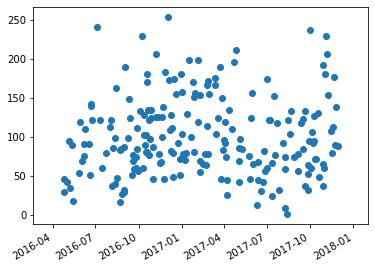

In [141]:
plt.scatter(all_data.date, all_data.tsm_nn)
plt.xticks(rotation=30, ha='right')

In [143]:
dst = f"sentinel3-{all_data.date.min():%Y%m%d}-{all_data.date.max():%Y%m%d}.csv"

all_data.to_csv(
    dst,
    index=False
)

## Pair with Isolate Performance

*In another notebook...*

---

In [23]:
dt_name = 'chl_oc4me'
testfiles =  glob(os.path.join(download_location, f"*/{dt_name}*.tif"))
f = rio.open(testfiles[20])

In [24]:
f.count

2